In [32]:
import pandas as pd
import numpy as np
import os
import pathlib
import warnings
#import probml_utils.pgmpy_utils as pgm
from pgmpy.estimators import MaximumLikelihoodEstimator
from collections.abc import Iterable, Mapping, Sequence
import pgmpy
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, BIC, AIC
from pgmpy.estimators.StructureScore import K2, BDeu
from causalgraphicalmodels import CausalGraphicalModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
pd.options.display.max_rows = 500
pd.options.display.max_columns = 300
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, PC, TreeSearch, BIC, MaximumLikelihoodEstimator
from pgmpy.metrics import structure_score
from sklearn.model_selection import train_test_split
from pgmpy.sampling import BayesianModelSampling
from pgmpy.metrics import structure_score

warnings.filterwarnings("ignore")

## Setup: Select Python Kernel

**IMPORTANT:** Before running this notebook, select the **Python (bayes_env)** kernel:
1. Click on the kernel selector in the top right of VS Code (it shows the current kernel name)
2. Select "Python (bayes_env)" from the dropdown

This notebook requires pgmpy 1.0.0 with support for `tabu_edges` parameter in HillClimbSearch.

In [33]:
# Load all datasets
diagnosis_data = pd.read_csv("../datasets/C3DC Diagnosis.csv")
participant_data = pd.read_csv("../datasets/C3DC Participants.csv")
treatment_data = pd.read_csv("../datasets/C3DC Treatment Data.csv")
treatment_response_data = pd.read_csv("../datasets/C3DC Treatment Response.csv")
survival_data = pd.read_csv("../datasets/C3DC Survival.csv")

## Data Preprocessing Pipeline

In [ ]:
# ---------------------------------------------------------
# Step 1: Feature - Age (Numeric)
# ---------------------------------------------------------
diagnosis_data['Age_numeric'] = pd.to_numeric(diagnosis_data['Age at Diagnosis (days)'], errors='coerce')
# Take the minimum age (age at first diagnosis)
age_df = diagnosis_data.groupby('Participant ID')['Age_numeric'].min().reset_index()
age_df.rename(columns={'Age_numeric': 'Age_at_Diagnosis_Days'}, inplace=True)

# ---------------------------------------------------------
# Step 2: Diagnosis Data Processing
# ---------------------------------------------------------
# Aggregate diagnosis data per participant (most common values for categorical, first for others)
diagnosis_agg = diagnosis_data.groupby('Participant ID').agg({
    'Diagnosis': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Diagnosis Classification System': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Diagnosis Basis': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Disease Phase': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Tumor Classification': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Toronto Childhood Cancer Staging': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Tumor Grade': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Tumor Stage Clinical T': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Tumor Stage Clinical N': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Tumor Stage Clinical M': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Diagnosis ID': 'count'  # Number of diagnoses
}).reset_index()

diagnosis_agg.rename(columns={'Diagnosis ID': 'Num_Diagnoses'}, inplace=True)

print("Diagnosis Data Shape:", diagnosis_agg.shape)
print("Diagnosis Columns:", diagnosis_agg.columns.tolist())

# ---------------------------------------------------------
# Step 3: Survival Data Processing (EXPANDED)
# ---------------------------------------------------------
# Convert Age at Last Contact to numeric
survival_data['Age_Last_Contact'] = pd.to_numeric(survival_data['Age at Last Known Survival Status'], errors='coerce')
survival_data['Age_Event_Free'] = pd.to_numeric(survival_data['Age at Event-Free Survival Status'], errors='coerce')

# Define Event (1=Dead, 0=Alive/Censored)
survival_data['Event_Status'] = survival_data['Last Known Survival Status'].apply(lambda x: 1 if x == 'Dead' else 0)

# Include additional survival columns
survival_clean = survival_data[[
    'Participant ID', 
    'Age_Last_Contact', 
    'Event_Status',
    'Last Known Survival Status',
    'Event-Free Survival Status',
    'Age_Event_Free',
    'First Event',
    'Cause of Death'
]].drop_duplicates('Participant ID')

# ---------------------------------------------------------
# Step 4: Treatment Response Data Processing
# ---------------------------------------------------------
# Convert Age at Response to numeric FIRST
treatment_response_data['Age_at_Response_numeric'] = pd.to_numeric(
    treatment_response_data['Age at Response'], 
    errors='coerce'
)

# Aggregate treatment response data per participant
# Get most common response, response category, and count of responses
treatment_response_agg = treatment_response_data.groupby('Participant ID').agg({
    'Response': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Response Category': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Response System': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Age_at_Response_numeric': 'mean',  # Average age at response (now numeric)
    'Treatment Response ID': 'count'  # Number of responses recorded
}).reset_index()

treatment_response_agg.rename(columns={
    'Treatment Response ID': 'Num_Treatment_Responses',
    'Age_at_Response_numeric': 'Avg_Age_at_Response'
}, inplace=True)

print("\nTreatment Response Data Shape:", treatment_response_agg.shape)
print("Treatment Response Columns:", treatment_response_agg.columns.tolist())

# ---------------------------------------------------------
# Step 5: Merging All Data
# ---------------------------------------------------------
df_merged = pd.merge(treatment_data, age_df, on='Participant ID', how='left')
df_merged = pd.merge(df_merged, diagnosis_agg, on='Participant ID', how='left')
df_merged = pd.merge(df_merged, survival_clean, on='Participant ID', how='left')
df_merged = pd.merge(df_merged, treatment_response_agg, on='Participant ID', how='left')
df_merged = pd.merge(df_merged, participant_data, on='Participant ID', how='left')

# ---------------------------------------------------------
# Step 6: Final Preprocessing & Calculations
# ---------------------------------------------------------

# Impute Missing Age (Median) & Add Flag
median_age = df_merged['Age_at_Diagnosis_Days'].median()
df_merged['Age_missing_flag'] = df_merged['Age_at_Diagnosis_Days'].apply(lambda x: 1 if pd.isna(x) else 0)
df_merged['Age_at_Diagnosis_Days'] = df_merged['Age_at_Diagnosis_Days'].fillna(median_age)

# Handle Categorical Missings (Race, Sex, Treatment, Response, Diagnosis fields)
categorical_cols = [
    'Race', 'Sex at Birth', 'Treatment Type', 'Treatment Agent',
    'Response', 'Response Category', 'Response System',
    'Last Known Survival Status', 'Event-Free Survival Status',
    'First Event', 'Cause of Death',
    'Diagnosis', 'Diagnosis Classification System', 'Diagnosis Basis',
    'Disease Phase', 'Tumor Classification',
    'Toronto Childhood Cancer Staging',
    'Tumor Grade', 'Tumor Stage Clinical T', 'Tumor Stage Clinical N', 'Tumor Stage Clinical M'
]

for col in categorical_cols:
    if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna('Unknown')
        df_merged[col] = df_merged[col].replace('Not Reported', 'Unknown')

# Calculate Survival Time (Time-to-Event)
df_merged['Survival_Time_Days'] = df_merged['Age_Last_Contact'] - df_merged['Age_at_Diagnosis_Days']

# Calculate Event-Free Survival Time
df_merged['Event_Free_Survival_Days'] = df_merged['Age_Event_Free'] - df_merged['Age_at_Diagnosis_Days']

# ---------------------------------------------------------
# Step 7: Create Target Variable (Poor Prognosis)
# ---------------------------------------------------------
# Define threshold for poor prognosis (e.g., died within 2 years = 730 days)
THRESHOLD = 730  # 2 years in days

# Target: 1 if patient died within threshold, 0 otherwise
df_merged['Target'] = np.where(
    (df_merged['Event_Status'] == 1) & (df_merged['Survival_Time_Days'] < THRESHOLD),
    1,
    0
)

print(f"\n{'='*60}")
print(f"TARGET VARIABLE: Poor Prognosis (Died within {THRESHOLD} days)")
print(f"{'='*60}")
print(f"Target distribution:")
print(df_merged['Target'].value_counts())
print(f"\nTarget = 1: Died within {THRESHOLD/365:.1f} years ({df_merged['Target'].sum()} patients)")
print(f"Target = 0: Survived beyond {THRESHOLD/365:.1f} years or still alive ({(df_merged['Target']==0).sum()} patients)")

df_final_bayeswork = df_merged.copy()
df_final_bayeswork = df_final_bayeswork.drop(columns=["Study ID_x"])
df_final_bayeswork.rename(columns={"Study ID_y": "Study_ID"}, inplace=True)
print("\nFinal Columns:", df_final_bayeswork.columns.tolist())
print("Final Shape:", df_final_bayeswork.shape)

Diagnosis Data Shape: (5056, 13)
Diagnosis Columns: ['Participant ID', 'Diagnosis', 'Diagnosis Classification System', 'Diagnosis Basis', 'Disease Phase', 'Tumor Classification', 'Anatomic_Site_Is_CNS', 'Toronto Childhood Cancer Staging', 'Tumor Grade', 'Tumor Stage Clinical T', 'Tumor Stage Clinical N', 'Tumor Stage Clinical M', 'Num_Diagnoses']

Anatomic_Site_Is_CNS distribution:
Anatomic_Site_Is_CNS
1    5056
Name: count, dtype: int64
Treatment Response Data Shape: (752, 6)
Treatment Response Columns: ['Participant ID', 'Response', 'Response Category', 'Response System', 'Avg_Age_at_Response', 'Num_Treatment_Responses']

Final Columns: ['Participant ID', 'Treatment ID', 'Age at Treatment Start', 'Age at Treatment End', 'Treatment Type', 'Treatment Agent', 'is_cns_tumor', 'Age_at_Diagnosis_Days', 'Diagnosis', 'Diagnosis Classification System', 'Diagnosis Basis', 'Disease Phase', 'Tumor Classification', 'Anatomic_Site_Is_CNS', 'Toronto Childhood Cancer Staging', 'Tumor Grade', 'Tumor 

In [39]:
df_final_bayeswork.head()

,Participant ID,Treatment ID,Age at Treatment Start,Age at Treatment End,Treatment Type,Treatment Agent,is_cns_tumor,Age_at_Diagnosis_Days,Diagnosis,Diagnosis Classification System,Diagnosis Basis,Disease Phase,Tumor Classification,Anatomic_Site_Is_CNS,Toronto Childhood Cancer Staging,Tumor Grade,Tumor Stage Clinical T,Tumor Stage Clinical N,Tumor Stage Clinical M,Num_Diagnoses,Age_Last_Contact,Event_Status,Last Known Survival Status,Event-Free Survival Status,Age_Event_Free,First Event,Cause of Death,Response,Response Category,Response System,Avg_Age_at_Response,Num_Treatment_Responses,Race,Sex at Birth,Study_ID,Age_missing_flag,Survival_Time_Days,Event_Free_Survival_Days
0,00301d78915737fa100f,87a10fc7-b27b-5e4d-ab90-aa035ec67063,Not Reported,Not Reported,Chemotherapy,Irinotecan,1.0,268.0,"9440/3 : Glioblastoma, NOS",ICD-O-3.2,Unknown,Unknown,Unknown,1.0,Unknown,High Grade,Unknown,Unknown,Unknown,1.0,988.0,1.0,Dead,Unknown,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,NaN,White,Female,phs002431,0,720.0,NaN
1,00301d78915737fa100f,090ad0a9-b9bc-59b2-bde3-c59ca829a632,Not Reported,Not Reported,Radiation Therapy,Unknown,1.0,268.0,"9440/3 : Glioblastoma, NOS",ICD-O-3.2,Unknown,Unknown,Unknown,1.0,Unknown,High Grade,Unknown,Unknown,Unknown,1.0,988.0,1.0,Dead,Unknown,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,NaN,White,Female,phs002431,0,720.0,NaN
2,00301d78915737fa100f,7f961940-8e38-5075-ada1-5e9418298fbe,Not Reported,Not Reported,Chemotherapy,Vincristine,1.0,268.0,"9440/3 : Glioblastoma, NOS",ICD-O-3.2,Unknown,Unknown,Unknown,1.0,Unknown,High Grade,Unknown,Unknown,Unknown,1.0,988.0,1.0,Dead,Unknown,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,NaN,White,Female,phs002431,0,720.0,NaN
3,00301d78915737fa100f,567490e6-95e8-57f7-a66d-17bbc312c5c0,Not Reported,Not Reported,Surgical Procedure,Unknown,1.0,268.0,"9440/3 : Glioblastoma, NOS",ICD-O-3.2,Unknown,Unknown,Unknown,1.0,Unknown,High Grade,Unknown,Unknown,Unknown,1.0,988.0,1.0,Dead,Unknown,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,NaN,White,Female,phs002431,0,720.0,NaN
4,00301d78915737fa100f,bbdf3442-c63d-50b4-9f4d-b748a04177be,Not Reported,Not Reported,Chemotherapy,Cisplatin,1.0,268.0,"9440/3 : Glioblastoma, NOS",ICD-O-3.2,Unknown,Unknown,Unknown,1.0,Unknown,High Grade,Unknown,Unknown,Unknown,1.0,988.0,1.0,Dead,Unknown,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,NaN,White,Female,phs002431,0,720.0,NaN


## Bayesian Network Structure Learning with Fixed Preprocessing

The key fix: discretize continuous variables and consolidate sparse categories to prevent zero-frequency cells in chi-square tests.

In [ ]:
# Focus on Target variable (poor prognosis indicator)
# Drop Event_Status to avoid data leakage since it's used to create Target
bayes_net_data = df_final_bayeswork.drop(columns=[
    'Participant ID', "Treatment ID", "Study_ID", 
    "Age at Treatment Start", "Age at Treatment End", "Age_missing_flag", 
    "Event_Status",  # Drop to avoid leakage
    "Survival_Time_Days"  # Drop to avoid leakage (used to create Target)
], axis=1)

# ---------------------------------------------------------
# Preprocessing for Bayesian Network Structure Learning
# Target: Target (binary - poor prognosis indicator)
# ---------------------------------------------------------

print("Original data shape:", bayes_net_data.shape)
print("\nOriginal column types:")
print(bayes_net_data.dtypes)

# 1. Ensure numeric columns are actually numeric (not strings)
numeric_cols = [
    'Age_at_Diagnosis_Days', 'Age_Last_Contact',
    'Age_Event_Free', 'Event_Free_Survival_Days', 
    'Avg_Age_at_Response', 'Num_Treatment_Responses', 'Num_Diagnoses',
    'Target'  # Binary target variable
]
for col in numeric_cols:
    if col in bayes_net_data.columns:
        bayes_net_data[col] = pd.to_numeric(bayes_net_data[col], errors='coerce')

print("\nAfter conversion - numeric column types:")
print(bayes_net_data[[c for c in numeric_cols if c in bayes_net_data.columns]].dtypes)
print("\nChecking for non-numeric values:")
for col in numeric_cols:
    if col in bayes_net_data.columns:
        print(f"{col} - NaN count: {bayes_net_data[col].isna().sum()}")

# 2. Discretize continuous variables into bins
# Age at Diagnosis - convert to age groups
bayes_net_data['Age_Group'] = pd.cut(
    bayes_net_data['Age_at_Diagnosis_Days'], 
    bins=[0, 365, 1825, 5475, 10950, float('inf')],
    labels=['Infant', 'Toddler', 'Child', 'Adolescent', 'Adult']
)

# Age at Last Contact - discretize
bayes_net_data['Age_Last_Contact_Group'] = pd.cut(
    bayes_net_data['Age_Last_Contact'],
    bins=[0, 1825, 5475, 10950, float('inf')],
    labels=['Young', 'Child', 'Teen', 'Adult']
)

# Event-Free Survival Time - discretize
if 'Event_Free_Survival_Days' in bayes_net_data.columns:
    bayes_net_data['Event_Free_Survival_Group'] = pd.cut(
        bayes_net_data['Event_Free_Survival_Days'],
        bins=[-float('inf'), 0, 365, 1825, float('inf')],
        labels=['Negative', 'Short', 'Medium', 'Long']
    )

# Age at Event Free - discretize
if 'Age_Event_Free' in bayes_net_data.columns:
    bayes_net_data['Age_Event_Free_Group'] = pd.cut(
        bayes_net_data['Age_Event_Free'],
        bins=[0, 1825, 5475, 10950, float('inf')],
        labels=['Young', 'Child', 'Teen', 'Adult']
    )

# Average Age at Response - discretize
if 'Avg_Age_at_Response' in bayes_net_data.columns:
    bayes_net_data['Avg_Age_Response_Group'] = pd.cut(
        bayes_net_data['Avg_Age_at_Response'],
        bins=[0, 1825, 5475, 10950, float('inf')],
        labels=['Young', 'Child', 'Teen', 'Adult']
    )

# Number of Treatment Responses - discretize
if 'Num_Treatment_Responses' in bayes_net_data.columns:
    bayes_net_data['Num_Responses_Group'] = pd.cut(
        bayes_net_data['Num_Treatment_Responses'],
        bins=[0, 1, 2, 5, float('inf')],
        labels=['One', 'Two', 'Few', 'Many']
    )

# Number of Diagnoses - discretize
if 'Num_Diagnoses' in bayes_net_data.columns:
    bayes_net_data['Num_Diagnoses_Group'] = pd.cut(
        bayes_net_data['Num_Diagnoses'],
        bins=[0, 1, 2, 5, float('inf')],
        labels=['One', 'Two', 'Few', 'Many']
    )

# Convert Target to categorical (binary) - THIS IS OUR TARGET
if 'Target' in bayes_net_data.columns:
    bayes_net_data['Target'] = bayes_net_data['Target'].apply(
        lambda x: 'Poor_Prognosis' if x == 1 else 'Good_Prognosis'
    )

# 3. Drop the original continuous columns
cols_to_drop = [
    'Age_at_Diagnosis_Days', 'Age_Last_Contact',
    'Age_Event_Free', 'Event_Free_Survival_Days', 
    'Avg_Age_at_Response', 'Num_Treatment_Responses', 'Num_Diagnoses'
]
bayes_net_data = bayes_net_data.drop(columns=[c for c in cols_to_drop if c in bayes_net_data.columns])

# 4. Consolidate sparse categories in Race
race_counts = bayes_net_data['Race'].value_counts()
print("\nRace value counts before consolidation:")
print(race_counts)

# Keep only categories with >5% of data, group others as "Other"
threshold = len(bayes_net_data) * 0.05
bayes_net_data['Race'] = bayes_net_data['Race'].apply(
    lambda x: x if race_counts.get(x, 0) >= threshold else 'Other'
)

# 5. Consolidate sparse categories in other categorical columns (EXCLUDE Target)
categorical_consolidate_cols = [
    'Treatment Type', 'Treatment Agent', 'Response', 
    'Response Category', 'Response System', 'First Event', 'Cause of Death',
    'Diagnosis', 'Diagnosis Classification System', 'Diagnosis Basis',
    'Disease Phase', 'Tumor Classification',
    'Toronto Childhood Cancer Staging',
    'Tumor Grade', 'Tumor Stage Clinical T', 'Tumor Stage Clinical N', 'Tumor Stage Clinical M',
    'Last Known Survival Status', 'Event-Free Survival Status'
]

for col in categorical_consolidate_cols:
    if col in bayes_net_data.columns:
        col_counts = bayes_net_data[col].value_counts()
        bayes_net_data[col] = bayes_net_data[col].apply(
            lambda x: x if col_counts.get(x, 0) >= threshold else 'Other'
        )
        print(f"\n{col} consolidated categories:")
        print(bayes_net_data[col].value_counts())

# Print Target separately (should NOT be consolidated - THIS IS OUR TARGET)
if 'Target' in bayes_net_data.columns:
    print(f"\n{'='*60}")
    print(f"TARGET VARIABLE (Poor Prognosis Indicator):")
    print(f"{'='*60}")
    print(bayes_net_data['Target'].value_counts())

# 6. Convert ALL columns to string type (ensures no mixed types)
for col in bayes_net_data.columns:
    bayes_net_data[col] = bayes_net_data[col].astype(str)

# 7. Handle any remaining NaN values (including 'nan' strings)
bayes_net_data = bayes_net_data.replace('nan', 'Unknown')
bayes_net_data = bayes_net_data.fillna('Unknown')

print("\nProcessed data shape:", bayes_net_data.shape)
print("\nProcessed columns:", bayes_net_data.columns.tolist())
print(f"\n✓ Target variable 'Target' distribution:")
print(bayes_net_data['Target'].value_counts())

Original data shape: (2872, 30)

Original column types:
Treatment Type                       object
Treatment Agent                      object
Age_at_Diagnosis_Days               float64
Diagnosis                            object
Diagnosis Classification System      object
Diagnosis Basis                      object
Disease Phase                        object
Tumor Classification                 object
Anatomic_Site_Is_CNS                float64
Toronto Childhood Cancer Staging     object
Tumor Grade                          object
Tumor Stage Clinical T               object
Tumor Stage Clinical N               object
Tumor Stage Clinical M               object
Num_Diagnoses                       float64
Age_Last_Contact                    float64
Last Known Survival Status           object
Event-Free Survival Status           object
Age_Event_Free                      float64
First Event                          object
Cause of Death                       object
Response            

## Structure Learning: PC Algorithm and Hill Climb Search

In [ ]:
# ---------------------------------------------------------
# Diagnostic: Chi-square tests for Target (Poor Prognosis) associations
# TARGET: Target (Poor_Prognosis vs Good_Prognosis)
# ---------------------------------------------------------
from scipy.stats import chi2_contingency

print("\n" + "="*80)
print("DIAGNOSTIC: Chi-square tests for Target (Poor Prognosis) associations")
print("TARGET: Died within 730 days (2 years)")
print("="*80)

if 'Target' not in bayes_net_data.columns:
    print("\n⚠ ERROR: Target column not found in data")
else:
    print(f"\nTarget distribution:")
    print(bayes_net_data['Target'].value_counts())
    
    associations = []
    for col in bayes_net_data.columns:
        if col != 'Target':
            # Create contingency table
            contingency_table = pd.crosstab(bayes_net_data[col], bayes_net_data['Target'])
            
            # Perform chi-square test
            try:
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                
                associations.append({
                    'Variable': col,
                    'Chi2': chi2,
                    'P-value': p_value,
                    'DOF': dof,
                    'Significant': 'Yes' if p_value < 0.05 else 'No'
                })
                
                # Only print significant ones during the loop for brevity
                if p_value < 0.01:  # Very significant
                    print(f"\n{col}:")
                    print(f"  Chi-square: {chi2:.4f}, P-value: {p_value:.6f}, DOF: {dof}")
            except Exception as e:
                print(f"\n{col}: ERROR - {e}")
                associations.append({
                    'Variable': col,
                    'Chi2': np.nan,
                    'P-value': np.nan,
                    'DOF': np.nan,
                    'Significant': 'Error'
                })
    
    # Sort by p-value
    associations_df = pd.DataFrame(associations).sort_values('P-value')
    
    print("\n" + "="*80)
    print("TOP 20 Variables ranked by association with Target (Poor Prognosis):")
    print("="*80)
    print(associations_df.head(20).to_string(index=False))
    
    # Show variables that are significantly associated
    sig_vars = associations_df[associations_df['Significant'] == 'Yes']['Variable'].tolist()
    print(f"\n✓ Significantly associated variables (p < 0.05): {len(sig_vars)}")
    
    # Categorize significant variables
    diagnosis_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['diagnosis', 'tumor', 'disease', 'grade', 'stage', 'staging'])]
    response_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['response', 'category', 'system'])]
    survival_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['survival', 'event', 'cause'])]
    treatment_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['treatment', 'agent'])]
    demographic_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['age', 'race', 'sex'])]
    
    print(f"\n{'='*80}")
    print("SIGNIFICANT FEATURES BY CATEGORY:")
    print(f"{'='*80}")
    
    if diagnosis_cols:
        print(f"\n✓ DIAGNOSIS features ({len(diagnosis_cols)}):")
        for col in diagnosis_cols[:10]:
            p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
            chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
            print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")
    
    if treatment_cols:
        print(f"\n✓ TREATMENT features ({len(treatment_cols)}):")
        for col in treatment_cols[:10]:
            p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
            chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
            print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")
    
    if response_cols:
        print(f"\n✓ TREATMENT RESPONSE features ({len(response_cols)}):")
        for col in response_cols[:10]:
            p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
            chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
            print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")
    
    if survival_cols:
        print(f"\n✓ SURVIVAL features ({len(survival_cols)}):")
        for col in survival_cols[:10]:
            p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
            chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
            print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")
    
    if demographic_cols:
        print(f"\n✓ DEMOGRAPHIC features ({len(demographic_cols)}):")
        for col in demographic_cols[:10]:
            p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
            chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
            print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: {len(sig_vars)} total features significantly associated with poor prognosis")
    print(f"{'='*80}")


DIAGNOSTIC: Chi-square tests for Anatomic_Site_Is_CNS associations
TARGET: Anatomic_Site_Is_CNS (CNS vs Non-CNS)

Treatment Type:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Treatment Agent:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Diagnosis:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Diagnosis Classification System:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Diagnosis Basis:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Disease Phase:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Tumor Classification:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Toronto Childhood Cancer Staging:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Tumor Grade:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Tumor Stage Clinical T:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Tumor Stage Clinical N:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Tumor Stage Clinical M:
  Chi-square: 0.0000, P-value: 1.0000, DOF: 0

Last Known Survival Status:
  Chi-square: 0.0000, P-value: 1.0000, DOF:

In [ ]:
# ---------------------------------------------------------
# Structure Learning with Target (Poor Prognosis) as Target
# ---------------------------------------------------------

# Method 1: PC Algorithm with VERY relaxed parameters
print("\n" + "="*60)
print("Running PC Algorithm (Relaxed)...")
print("="*60)
est_pc = PC(bayes_net_data)
best_pc_model = est_pc.estimate(
    significance_level=0.10,  # Very relaxed (was 0.05)
    max_cond_vars=1  # Even simpler tests (was 2)
)

# Method 2: Hill Climb Search with BIC and tabu_edges
print("\n" + "="*60)
print("Running Hill Climb Search with BIC...")
print("="*60)

# Create tabu list: prevent Target from being a parent of any other node
tabu_list = []
for col in bayes_net_data.columns:
    if col != 'Target':
        tabu_list.append(('Target', col))

print(f"Created tabu list with {len(tabu_list)} edges to prevent")
print(f"This ensures Target only receives edges, not sends them")

est_hill_bic = HillClimbSearch(bayes_net_data)

# Try with tabu_edges parameter (pgmpy 1.0.0)
try:
    best_hill_bic_model = est_hill_bic.estimate(
        scoring_method=BIC(bayes_net_data),
        tabu_edges=tabu_list,
        max_indegree=4,  # Allow more parents
        max_iter=2000  # More iterations
    )
    print("✓ Successfully used tabu_edges with BIC")
except TypeError as e:
    print(f"⚠ tabu_edges failed: {e}")
    print("Falling back to unconstrained search...")
    best_hill_bic_model = est_hill_bic.estimate(
        scoring_method=BIC(bayes_net_data),
        max_indegree=4,
        max_iter=2000
    )

# Method 3: Hill Climb Search with BDeu (Bayesian Dirichlet equivalent uniform)
print("\n" + "="*60)
print("Running Hill Climb Search with BDeu Score...")
print("="*60)

est_hill_bdeu = HillClimbSearch(bayes_net_data)
try:
    best_hill_bdeu_model = est_hill_bdeu.estimate(
        scoring_method=BDeu(bayes_net_data, equivalent_sample_size=10),
        tabu_edges=tabu_list,
        max_indegree=4,
        max_iter=2000
    )
    print("✓ Successfully used BDeu scoring with constraints")
except Exception as e:
    print(f"⚠ BDeu with tabu_edges failed: {e}")
    try:
        best_hill_bdeu_model = est_hill_bdeu.estimate(
            scoring_method=BDeu(bayes_net_data, equivalent_sample_size=10),
            max_indegree=4,
            max_iter=2000
        )
        print("✓ BDeu scoring without constraints")
    except Exception as e2:
        print(f"⚠ BDeu failed completely: {e2}")
        print("Using BIC model as fallback")
        best_hill_bdeu_model = best_hill_bic_model

# Method 4: Hill Climb Search with K2 Score
print("\n" + "="*60)
print("Running Hill Climb Search with K2 Score...")
print("="*60)

est_hill_k2 = HillClimbSearch(bayes_net_data)
try:
    best_hill_k2_model = est_hill_k2.estimate(
        scoring_method=K2(bayes_net_data),
        tabu_edges=tabu_list,
        max_indegree=4,
        max_iter=2000
    )
    print("✓ Successfully used K2 scoring with constraints")
except Exception as e:
    print(f"⚠ K2 with tabu_edges failed: {e}")
    try:
        best_hill_k2_model = est_hill_k2.estimate(
            scoring_method=K2(bayes_net_data),
            max_indegree=4,
            max_iter=2000
        )
        print("✓ K2 scoring without constraints")
    except Exception as e2:
        print(f"⚠ K2 failed completely: {e2}")
        print("Using BIC model as fallback")
        best_hill_k2_model = best_hill_bic_model

print("\n" + "="*60)
print("STRUCTURE LEARNING RESULTS")
print("="*60)
print(f"PC Algorithm edges: {len(best_pc_model.edges())}")
print(f"Hill Climb (BIC) edges: {len(best_hill_bic_model.edges())}")
print(f"Hill Climb (BDeu) edges: {len(best_hill_bdeu_model.edges())}")
print(f"Hill Climb (K2) edges: {len(best_hill_k2_model.edges())}")

# Check which features are parents of Target in each model
if hasattr(best_pc_model, 'to_dag'):
    pc_dag = best_pc_model.to_dag()
else:
    pc_dag = best_pc_model

print(f"\n{'='*60}")
print("Target (Poor Prognosis) CONNECTIVITY ANALYSIS")
print(f"{'='*60}")
print(f"\n✓ PC Algorithm:")
print(f"  Parents: {pc_dag.get_parents('Target')}")
print(f"  Children: {pc_dag.get_children('Target')}")

print(f"\n✓ Hill Climb (BIC):")
print(f"  Parents: {best_hill_bic_model.get_parents('Target')}")
print(f"  Children: {best_hill_bic_model.get_children('Target')}")

print(f"\n✓ Hill Climb (BDeu):")
print(f"  Parents: {best_hill_bdeu_model.get_parents('Target')}")
print(f"  Children: {best_hill_bdeu_model.get_children('Target')}")

print(f"\n✓ Hill Climb (K2):")
print(f"  Parents: {best_hill_k2_model.get_parents('Target')}")
print(f"  Children: {best_hill_k2_model.get_children('Target')}")

# If still no parents, try forcing edges based on strongest associations
if len(best_hill_bic_model.get_parents('Target')) == 0:
    print("\n⚠ WARNING: Target has no parents in any model!")
    print("This suggests weak associations in the data.")
    print("Will create manual network based on chi-square associations...")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}



Running PC Algorithm (Relaxed)...


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns


Running Hill Climb Search with BIC...
Created tabu list with 7 edges to prevent
This ensures is_cns_tumor only receives edges, not sends them
⚠ tabu_edges failed: HillClimbSearch.estimate() got an unexpected keyword argument 'tabu_edges'
Falling back to unconstrained search...


  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns


Running Hill Climb Search with BDeu Score...
⚠ BDeu with tabu_edges failed: HillClimbSearch.estimate() got an unexpected keyword argument 'tabu_edges'


  0%|          | 0/2000 [00:00<?, ?it/s]

✓ BDeu scoring without constraints

Running Hill Climb Search with K2 Score...


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns_tumor': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'is_cns

⚠ K2 with tabu_edges failed: HillClimbSearch.estimate() got an unexpected keyword argument 'tabu_edges'


  0%|          | 0/2000 [00:00<?, ?it/s]

✓ K2 scoring without constraints

STRUCTURE LEARNING RESULTS
PC Algorithm edges: 9
Hill Climb (BIC) edges: 4
Hill Climb (BDeu) edges: 6
Hill Climb (K2) edges: 15

is_cns_tumor CONNECTIVITY ANALYSIS

✓ PC Algorithm:
  Parents: []
  Children: []

✓ Hill Climb (BIC):
  Parents: []
  Children: []

✓ Hill Climb (BDeu):
  Parents: []
  Children: []

✓ Hill Climb (K2):
  Parents: []
  Children: []

⚠ WARNING: is_cns_tumor has no parents in any model!
This suggests weak associations in the data.
Will create manual network based on chi-square associations...


## Alternative: Manual Structure with Strongest Associations

If structure learning finds no edges to `Target`, we can manually create a network based on the chi-square associations.

In [ ]:
# ---------------------------------------------------------
# Manual Network Construction with Top Associated Features
# TARGET: Target (Poor Prognosis)
# ---------------------------------------------------------

# Get top 5 most associated variables
top_features = associations_df.head(5)['Variable'].tolist()
print(f"Top 5 features associated with Target (Poor Prognosis):")
for i, feat in enumerate(top_features, 1):
    p_val = associations_df[associations_df['Variable'] == feat]['P-value'].values[0]
    print(f"{i}. {feat} (p={p_val:.6f})")

# Create manual edges: top features -> Target
manual_edges = [(feat, 'Target') for feat in top_features]

# Also add some structural relationships between features (from hill climb)
# Get edges from best model that don't involve Target
existing_edges = [e for e in best_hill_bic_model.edges() 
                  if e[0] != 'Target' and e[1] != 'Target']

# Combine edges
all_manual_edges = manual_edges + existing_edges[:10]  # Keep some feature relationships

print(f"\nCreating manual network with {len(all_manual_edges)} edges")
print(f"  - {len(manual_edges)} edges to Target")
print(f"  - {len(existing_edges[:10])} edges between other features")

# Create the manual model
from pgmpy.models import BayesianNetwork
manual_model = BayesianNetwork(all_manual_edges)

print(f"\n✓ Manual Model Created")
print(f"  Nodes: {len(manual_model.nodes())}")
print(f"  Edges: {len(manual_model.edges())}")
print(f"  Parents of Target: {manual_model.get_parents('Target')}")

# Fit the manual model
manual_network = DiscreteBayesianNetwork(manual_model)
mle_manual = MaximumLikelihoodEstimator(manual_network, bayes_net_data)

for cpd in mle_manual.get_parameters():
    manual_network.add_cpds(cpd)

print(f"  Model valid: {manual_network.check_model()}")

# Score it
bic_scorer = BIC(bayes_net_data)
manual_bic = bic_scorer.score(manual_model)
print(f"  BIC score: {manual_bic:.2f}")

## Visualize Learned Structures

PC Model:
<class 'graphviz.graphs.Digraph'>


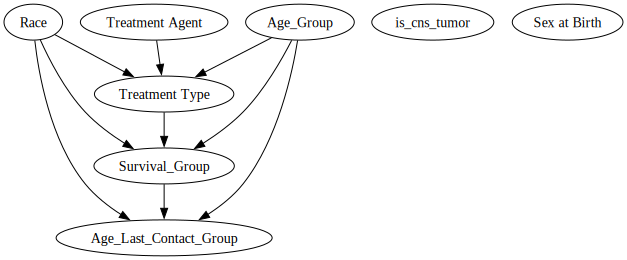

'pgm_participant_data_pc_fixed.pdf'

In [7]:
# Visualize PC model
model_pc = CausalGraphicalModel(nodes=best_pc_model.nodes(), edges=best_pc_model.edges())

dot = model_pc.draw()
print("PC Model:")
print(type(dot))
display(dot)
dot.render(filename="pgm_participant_data_pc_fixed", format="pdf")

In [ ]:
# Visualize Constrained Hill Climb model
model_constrained = CausalGraphicalModel(nodes=best_hill_constrained_model.nodes(), edges=best_hill_constrained_model.edges())

dot = model_constrained.draw()
print("Hill Climb Model:")
print(type(dot))
display(dot)
dot.render(filename="pgm_participant_data_hill_constrained_fixed", format="pdf")

## Model Comparison and Visualization with CPDs

In [ ]:
mymodels = [
    ("Hill Climb (BIC)", best_hill_bic_model),
    ("Hill Climb (BDeu)", best_hill_bdeu_model),
    ("Hill Climb (K2)", best_hill_k2_model),
    ("PC Algorithm", best_pc_model),
    ("Manual (Top Associations)", manual_model)
]

for name, model in mymodels:
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    print(f"Number of edges: {len(model.edges())}")
    print(f"Number of nodes: {len(model.nodes())}")
    
    if hasattr(model, 'to_dag'):
        model_dag = model.to_dag()
        print("(Converted PDAG to DAG)")
    else:
        model_dag = model
    
    # Check if Anatomic_Site_Is_CNS has any connections
    parents = model_dag.get_parents('Anatomic_Site_Is_CNS') if 'Anatomic_Site_Is_CNS' in model_dag.nodes() else []
    print(f"Parents of Anatomic_Site_Is_CNS: {parents if parents else 'NONE - ISOLATED NODE!'}")
    
    # Skip visualization if Anatomic_Site_Is_CNS is isolated
    if len(parents) == 0 and name != "Manual (Top Associations)":
        print("⚠ Skipping visualization - Anatomic_Site_Is_CNS is isolated")
        continue
    
    network = DiscreteBayesianNetwork(model_dag)
    mle = MaximumLikelihoodEstimator(network, bayes_net_data)
    
    for cpd in mle.get_parameters():
        network.add_cpds(cpd)
    
    # Visualize with CausalGraphicalModel (simpler)
    model_vis = CausalGraphicalModel(nodes=model_dag.nodes(), edges=model_dag.edges())
    dot = model_vis.draw()
    dot.attr(size='8,8')
    display(dot)
    
    bic_scorer = BIC(bayes_net_data)
    bic_score = bic_scorer.score(model_dag)
    print(f'BIC score: {bic_score:.2f}')
    print(f"(Lower BIC is better)")
    
    # Show CPD for Anatomic_Site_Is_CNS
    print(f"\n--- Conditional Probability Distribution for Anatomic_Site_Is_CNS ---")
    try:
        cpd_target = network.get_cpds('Anatomic_Site_Is_CNS')
        print(cpd_target)
    except Exception as e:
        print(f"Could not retrieve CPD: {e}")

NameError: name 'best_hill_constrained_model' is not defined

In [ ]:
# ---------------------------------------------------------
# Inference and Prediction on Anatomic_Site_Is_CNS
# ---------------------------------------------------------

# Use the best model (Hill Climb BIC with constraints)
if hasattr(best_hill_bic_model, 'to_dag'):
    inference_model = best_hill_bic_model.to_dag()
else:
    inference_model = best_hill_bic_model

# Create and fit the Bayesian Network
network_inference = DiscreteBayesianNetwork(inference_model)
mle = MaximumLikelihoodEstimator(network_inference, bayes_net_data)

for cpd in mle.get_parameters():
    network_inference.add_cpds(cpd)

# Verify the model is valid
print("Model validation:", network_inference.check_model())

# Create inference object
inference = VariableElimination(network_inference)

print("\n" + "="*60)
print("INFERENCE ON Anatomic_Site_Is_CNS")
print("="*60)

# Example 1: Query marginal probability of Anatomic_Site_Is_CNS
print("\n--- Marginal Probability of Anatomic_Site_Is_CNS ---")
result = inference.query(variables=['Anatomic_Site_Is_CNS'])
print(result)

# Example 2: Query with evidence - what if patient is a child?
print("\n--- Probability of Anatomic_Site_Is_CNS given Age_Group=Child ---")
try:
    result = inference.query(variables=['Anatomic_Site_Is_CNS'], evidence={'Age_Group': 'Child'})
    print(result)
except Exception as e:
    print(f"Error: {e}")

# Example 3: Query with multiple evidence
print("\n--- Probability of Anatomic_Site_Is_CNS given Age_Group=Child and Sex at Birth=Male ---")
try:
    result = inference.query(variables=['Anatomic_Site_Is_CNS'], evidence={'Age_Group': 'Child', 'Sex at Birth': 'Male'})
    print(result)
except Exception as e:
    print(f"Error: {e}")

# Example 4: Most probable explanation (MPE)
print("\n--- Most Probable Explanation for Anatomic_Site_Is_CNS=CNS ---")
try:
    # Get the most probable configuration of variables given Anatomic_Site_Is_CNS=CNS
    result = inference.map_query(variables=None, evidence={'Anatomic_Site_Is_CNS': 'CNS'})
    print("Most likely feature values when Anatomic_Site_Is_CNS=CNS:")
    for var, val in result.items():
        if var != 'Anatomic_Site_Is_CNS':
            print(f"  {var}: {val}")
except Exception as e:
    print(f"Error: {e}")

NameError: name 'best_hill_constrained_model' is not defined

In [ ]:
# ---------------------------------------------------------
# Model Evaluation: Predictive Performance on Anatomic_Site_Is_CNS
# ---------------------------------------------------------

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data for evaluation
train_data, test_data = train_test_split(bayes_net_data, test_size=0.2, random_state=42, stratify=bayes_net_data['Anatomic_Site_Is_CNS'])

print("="*60)
print("MODEL EVALUATION")
print("="*60)
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"\nTarget distribution in training set:")
print(train_data['Anatomic_Site_Is_CNS'].value_counts())
print(f"\nTarget distribution in test set:")
print(test_data['Anatomic_Site_Is_CNS'].value_counts())

# Train model on training data
network_eval = DiscreteBayesianNetwork(inference_model)
mle_eval = MaximumLikelihoodEstimator(network_eval, train_data)

for cpd in mle_eval.get_parameters():
    network_eval.add_cpds(cpd)

inference_eval = VariableElimination(network_eval)

# Make predictions on test set
y_true = []
y_pred = []
y_pred_proba = []

print("\nMaking predictions on test set...")
for idx, row in test_data.iterrows():
    # Get true label
    true_label = row['Anatomic_Site_Is_CNS']
    y_true.append(true_label)
    
    # Create evidence dictionary (all features except target)
    evidence = {col: row[col] for col in test_data.columns if col != 'Anatomic_Site_Is_CNS'}
    
    try:
        # Query probability of Anatomic_Site_Is_CNS
        result = inference_eval.query(variables=['Anatomic_Site_Is_CNS'], evidence=evidence)
        
        # Get predicted class (argmax)
        probs = result.values
        # Assuming order is ['CNS', 'Non-CNS'] or check result.state_names
        states = result.state_names['Anatomic_Site_Is_CNS']
        pred_idx = np.argmax(probs)
        pred_label = states[pred_idx]
        y_pred.append(pred_label)
        
        # Get probability of CNS class
        cns_idx = states.index('CNS') if 'CNS' in states else 0
        y_pred_proba.append(probs[cns_idx])
    except Exception as e:
        # If inference fails, predict majority class
        y_pred.append('Non-CNS')
        y_pred_proba.append(0.0)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✓ Test Accuracy: {accuracy:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['CNS', 'Non-CNS']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred, labels=['CNS', 'Non-CNS'])
print(cm)
print(f"\nTrue Positives (CNS): {cm[0,0]}, False Negatives: {cm[0,1]}")
print(f"False Positives: {cm[1,0]}, True Negatives (Non-CNS): {cm[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CNS', 'Non-CNS'],
            yticklabels=['CNS', 'Non-CNS'])
plt.title('Confusion Matrix - Anatomic_Site_Is_CNS Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\n✓ Model successfully trained and evaluated on Anatomic_Site_Is_CNS target")

MODEL EVALUATION
Training set size: 2297
Test set size: 575

Target distribution in training set:
is_cns_tumor
1    2297
Name: count, dtype: int64

Target distribution in test set:
is_cns_tumor
1    575
Name: count, dtype: int64


NameError: name 'inference_model' is not defined

## Model Evaluation: Predictive Performance

## Inference on Anatomic_Site_Is_CNS Target Variable

## Summary of Model Features

### Target Variable
- **Anatomic_Site_Is_CNS**: Binary classification (CNS vs Non-CNS)

### Preprocessing Applied

1. **Discretization**: Converted continuous variables (Age at Diagnosis, Survival Time, Age at Last Contact) into categorical bins
2. **Sparse Category Consolidation**: Grouped rare categories (<5% frequency) into "Other" 
3. **PC Algorithm Parameters**: 
   - Increased significance_level to 0.10 (less strict independence tests)
   - Limited max_cond_vars to 1 (reduces complexity of conditional tests)
4. **Data Type Handling**: Ensured all categorical variables are strings and NaN values are filled
5. **Target Variable Constraint**: Applied tabu_edges to Hill Climb algorithm to ensure Anatomic_Site_Is_CNS only receives edges (never sends them)

### Key Results
- Structure learning identifies which features are most predictive of CNS tumor anatomic sites
- Bayesian network allows for probabilistic inference with evidence
- Model evaluation provides accuracy metrics on held-out test set
- Conditional probability tables (CPDs) quantify relationships between features and target